In [1]:
import music21 as ms
import numpy as np
import scipy as sp
import defusedxml
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
defusedxml.defuse_stdlib()

{<module 'defusedxml.xmlrpc' from 'c:\\Users\\home1\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\defusedxml\\xmlrpc.py'>: None,
 <module 'defusedxml.cElementTree' from 'c:\\Users\\home1\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\defusedxml\\cElementTree.py'>: <module 'xml.etree.cElementTree' from 'c:\\Users\\home1\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\xml\\etree\\cElementTree.py'>,
 <module 'defusedxml.ElementTree' from 'c:\\Users\\home1\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\defusedxml\\ElementTree.py'>: <module 'xml.etree.ElementTree' from 'c:\\Users\\home1\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\xml\\etree\\ElementTree.py'>,
 <module 'defusedxml.minidom' from 'c:\\Users\\home1\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\defusedxml\\minidom.py'>: <module 'xml.dom.minidom' from 'c:\\Users\\home1\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\xml\\dom\\minidom.py'>,


In [2]:
def process_file(filepath):
    parsed_file = ms.converter.parse(filepath)
    flattened_file = parsed_file.chordify().flatten()
    return flattened_file

In [3]:
def get_tempo(file):
    tempo = file.getElementsByClass(ms.tempo.MetronomeMark)
    if len(tempo) > 0:
        return tempo[0].getQuarterBPM()
    return 120

In [4]:
class ParsedChords:
    def __init__(self, parsed_file_chords):
        self.parsed_file_chords = parsed_file_chords

        # Sequence of chords
        self.sequence = []
        self.numerical_sequence = []

        # States
        self.state_names = []
        self.numerical_states = []
        self.states_freq = {}

        # Translating states to names and chords
        self.state_name_to_chords = {}
        self.state_number_to_name = {}
        self.state_name_to_number = {}

        # Velocity
        self.velocity_transition_matrix_dict = {}
        self.velocity_sequence = []
        self.velocity_states = []

        # Length of the song
        self.length = len(self.parsed_file_chords)
        
        # Song name
        self.song_name = ""

        # Tempo
        self.tempo = 120

        self.set_states()

    # Set states
    def set_states(self):
        for i in range(len(self.parsed_file_chords)):
            c = self.parsed_file_chords[i]
            self.state_name_to_chords[c.fullName] = (list(c.pitches), c.duration.quarterLength)
            self.sequence.append(c.fullName)

            # Volume
            c.volume.velocity = float(c.volume.getRealizedStr()) * 127
            self.velocity_sequence.append(c.volume.velocity)
            if c.volume.velocity not in self.velocity_states:
                self.velocity_states.append(c.volume.velocity)
        
        self.state_names = list(dict.fromkeys(self.sequence))
        self.numerical_states = range(len(self.state_names))

        for i in self.numerical_states:
            self.state_number_to_name[i] = self.state_names[i]
            self.state_name_to_number[self.state_names[i]] = i  
        
        for i in self.sequence:
            self.numerical_sequence.append(self.state_name_to_number[i])
        self.states_freq = Counter(self.numerical_sequence)

    # Show score
    def show_score(self):
        self.parsed_file_chords.stream().show()
    
    # Show midi
    def show_midi(self):
        self.parsed_file_chords.stream().show('midi')

    # Change song length
    def set_length(self, length):
        self.length = length

    # Set tempo
    def set_tempo(self, tempo):
        self.tempo = tempo

    # Set song name
    def set_song_name(self, name):
        self.song_name = name

    # Graph original velocity
    def graph_original_velocity(self):
        x = range(len(self.velocity_sequence))
        y = self.velocity_sequence
        plt.scatter(x, y, s=1)
        plt.xlabel('Time')
        plt.ylabel('Velocity')
        plt.title('Velocity of Original ' + self.song_name)
        plt.savefig('Pictures\\velocity_original_' + self.song_name + '.png')
        plt.show()

In [5]:
def generate_transition_matrix(numerical_states, sequence):
    n = len(numerical_states)

    # Initialize transition matrix
    transition_matrix = np.zeros((n, n))

    # Generate transition matrix
    for i in range(len(sequence)-1):
        transition_matrix[sequence[i]][sequence[i+1]] += 1

    # Normalize transition matrix
    for i in range(n):
        # If there are transitions from state i, normalize them
        if np.sum(transition_matrix[i]) != 0:
            transition_matrix[i] = transition_matrix[i]/np.sum(transition_matrix[i])
        # If there is no transition from state i, set all transitions to 1/n
        else:
            transition_matrix[i] = np.ones(n)/n

    # If final state is absorbing, set all transitions to 1/n
    if transition_matrix[n-1][n-1] == 1:
        transition_matrix[n-1][n-1] = np.ones(n)/n
    
    # Check if transition matrix is valid
        if abs(np.sum(transition_matrix)-n) > 1e-6:
            print("Error in initial matrix")
    
    return transition_matrix

In [6]:
def generate_initial_matrix(numerical_states, states_freq):
    # Initialize initial matrix
    initial_matrix = np.zeros(len(numerical_states))

    # Fill initial matrix
    for i in range(len(numerical_states)):
        initial_matrix[i] = states_freq[numerical_states[i]]
    
    # Normalize transition matrix
    initial_matrix = initial_matrix/np.sum(initial_matrix)

    # Check if initial matrix is valid
    if abs(np.sum(initial_matrix)-1) > 1e-6:
        print("Error in initial matrix")
    
    return initial_matrix

In [7]:
def generate_hidden_to_emission_tm_dict(hidden_states, emission_states, hidden_sequence, emission_sequence):
    hidden_to_emission_tm_dict = {}
    emission_tm_to_emission_states = {}

    # Create a dictionary to map emission states to their indices
    for i in range(len(emission_states)):
        emission_tm_to_emission_states[i] = emission_states[i]

    # Create a dictionary to map hidden states to their emission states
    for i in hidden_states:
        working_vector = np.zeros(len(emission_states))
        indices = [j for j in range(len(hidden_sequence)) if hidden_sequence[j] == i]
        for k in indices:
            working_vector[emission_states.index(emission_sequence[k])] += 1
        working_vector = working_vector / sum(working_vector)
        hidden_to_emission_tm_dict[i] = working_vector
    return hidden_to_emission_tm_dict, emission_tm_to_emission_states

In [8]:
def chord_builder(state, iter, state_number_to_name, state_name_to_chords, hidden_to_emission_tm_dict, emission_tm_to_emission_states):
    pitch, duration = state_name_to_chords[state_number_to_name[state]]
    velocity = emission_tm_to_emission_states[
        np.random.choice(list(emission_tm_to_emission_states.keys()), p=hidden_to_emission_tm_dict[state])
        ]
    chord = ms.chord.Chord(pitch, quarterLength=duration)
    chord.volume.velocity = velocity
    return velocity, chord

In [9]:
def generate_song(parsed_chords, initial_matrix, transition_matrix, 
                  hidden_to_emission_tm_dict, emission_tm_to_emission_states, velocity_viz=False, iter=0):
    # Get the necessary variables
    numerical_states = parsed_chords.numerical_states
    length = parsed_chords.length
    state_name_to_chord = parsed_chords.state_name_to_chords
    state_number_to_name = parsed_chords.state_number_to_name
    tempo = ms.tempo.MetronomeMark(number=parsed_chords.tempo)


    # Initialize stream object
    song = ms.stream.Stream()

    # Initialize velocity x, y list
    if velocity_viz == True:
        x = range(length)
        y = []

    # Generate first note
    current_state = np.random.choice(numerical_states, p=initial_matrix)

    # Build chord object
    velocity, chord = chord_builder(current_state, 0, state_number_to_name, state_name_to_chord, 
                                    hidden_to_emission_tm_dict, emission_tm_to_emission_states)
    if velocity_viz == True:
        y.append(velocity)
    song.append(chord)

    for i in range(length-1):
        # Get next state
        current_state = np.random.choice(numerical_states, p=transition_matrix[current_state])
        
        # Build chord object
        velocity, chord = chord_builder(current_state, i, state_number_to_name, state_name_to_chord, 
                                        hidden_to_emission_tm_dict, emission_tm_to_emission_states)
        
        if velocity_viz == True:
            y.append(velocity)
        
        song.append(chord)
    
    # Set tempo
    song.insert(0.0, tempo)

    # Graph velocity
    if velocity_viz == True:
        plt.scatter(x, y, s=1)
        plt.xlabel('Time')
        plt.ylabel('Velocity')
        plt.title('Velocity of Generated ' + parsed_chords.song_name + ' ' + str(iter))
        plt.savefig('Pictures\\velocity_generated_SMM' + parsed_chords.song_name + '_' + str(iter) + '.png')
        plt.show()

    return song

In [10]:
def export_song(song, song_name, model='_simple_', number=0):
    song.write('midi', fp='Generated Music\\SMM\\'+ song_name + model + str(number) + '.mid')
    song.write('mxl', fp='Generated Music\\SMM\\'+ song_name + model + str(number) + '.mxl')

In [11]:
def song_pipeline(filepath, song_name, number_of_generations=1, velocity_viz=False):
    # Process file
    processed_file = process_file(filepath)
    parsed_chords = ParsedChords(processed_file.getElementsByClass('Chord'))

    # Set tempo and song name
    tempo = get_tempo(processed_file)
    parsed_chords.set_tempo(tempo)
    parsed_chords.set_song_name(song_name)

    # If velocity visualization is required
    if velocity_viz == True:
        parsed_chords.graph_original_velocity()

    # Generate transition matrix and initial matrix
    transition_matrix = generate_transition_matrix(parsed_chords.numerical_states, parsed_chords.numerical_sequence)
    initial_matrix = generate_initial_matrix(parsed_chords.numerical_states, parsed_chords.states_freq)
    velocity_tmd, velocity_td = generate_hidden_to_emission_tm_dict(parsed_chords.numerical_states, 
                                                                    parsed_chords.velocity_states, 
                                                                    parsed_chords.numerical_sequence, 
                                                                    parsed_chords.velocity_sequence)

    # Generate songs
    for i in range(number_of_generations):
        song = generate_song(parsed_chords, initial_matrix, transition_matrix, velocity_tmd, velocity_td, velocity_viz, i)
        export_song(song, song_name, number=i)
        print('song_name:', song_name, ', number:', i)

In [12]:
def run_multiple_songs(filepaths, song_names, number_of_generations=1, velocity_viz=False):
    for i in range(len(filepaths)):
        song_pipeline(filepaths[i], song_names[i], number_of_generations, velocity_viz)

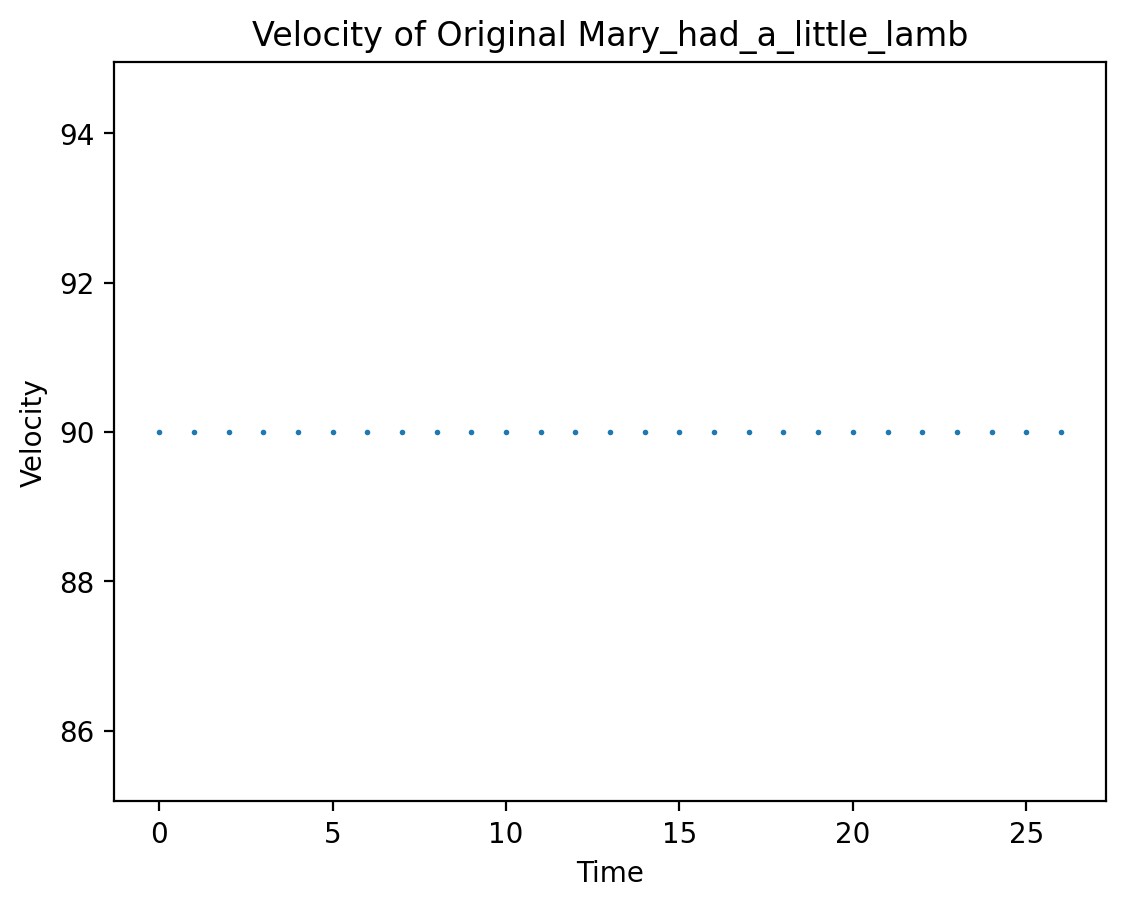

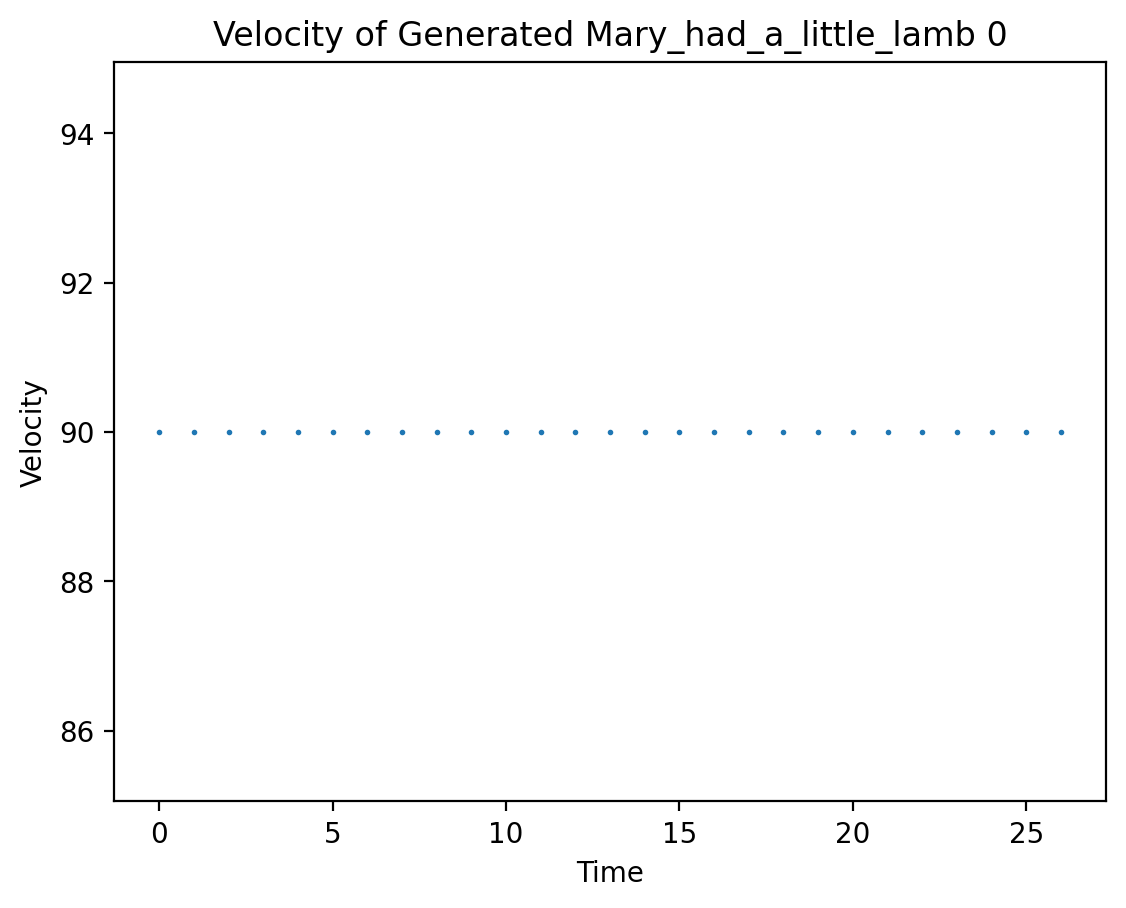

song_name: Mary_had_a_little_lamb , number: 0


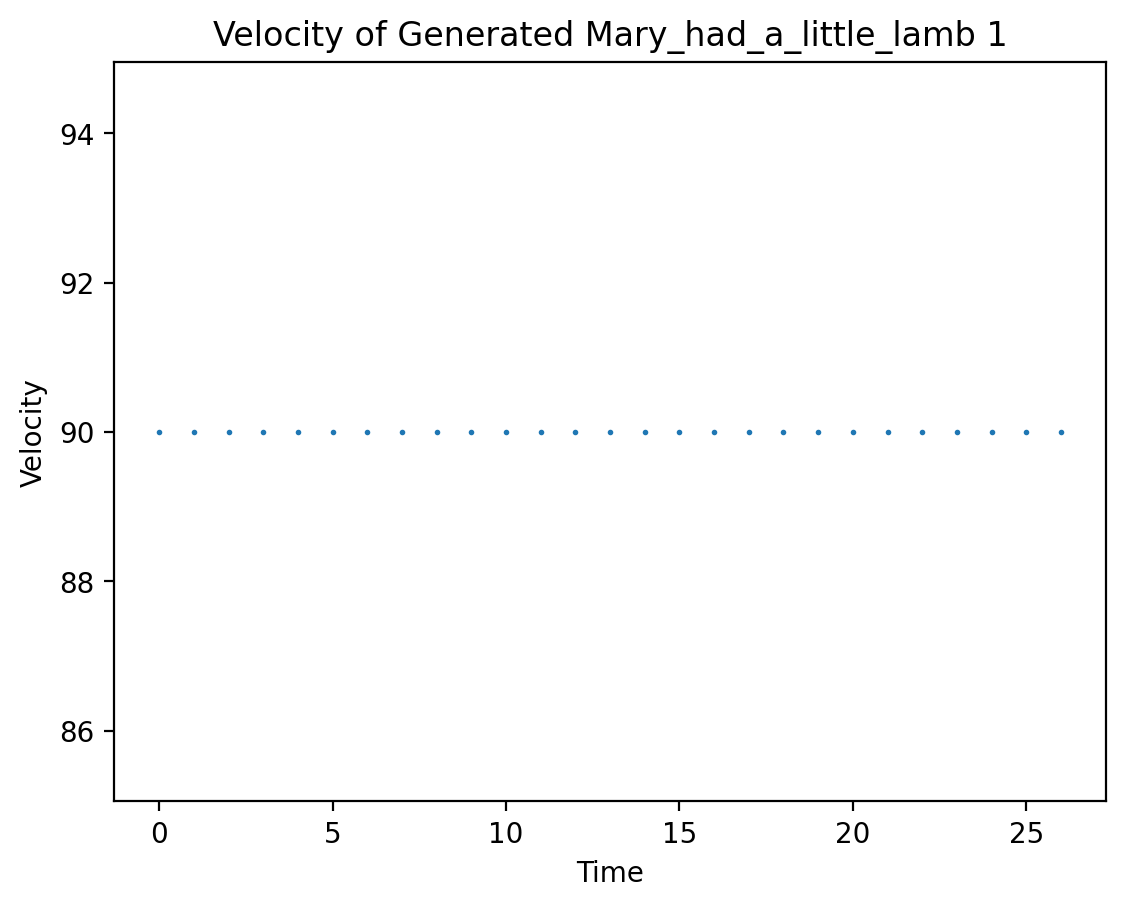

song_name: Mary_had_a_little_lamb , number: 1


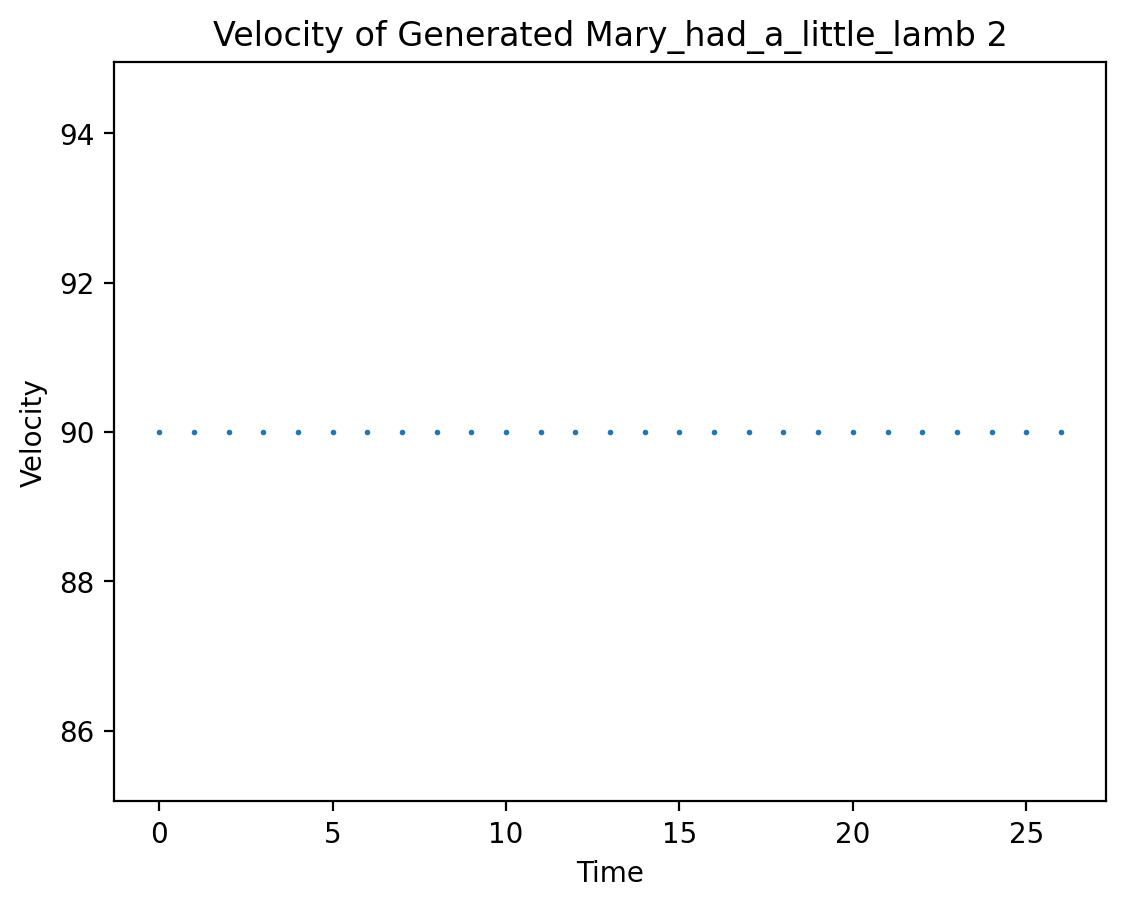

song_name: Mary_had_a_little_lamb , number: 2


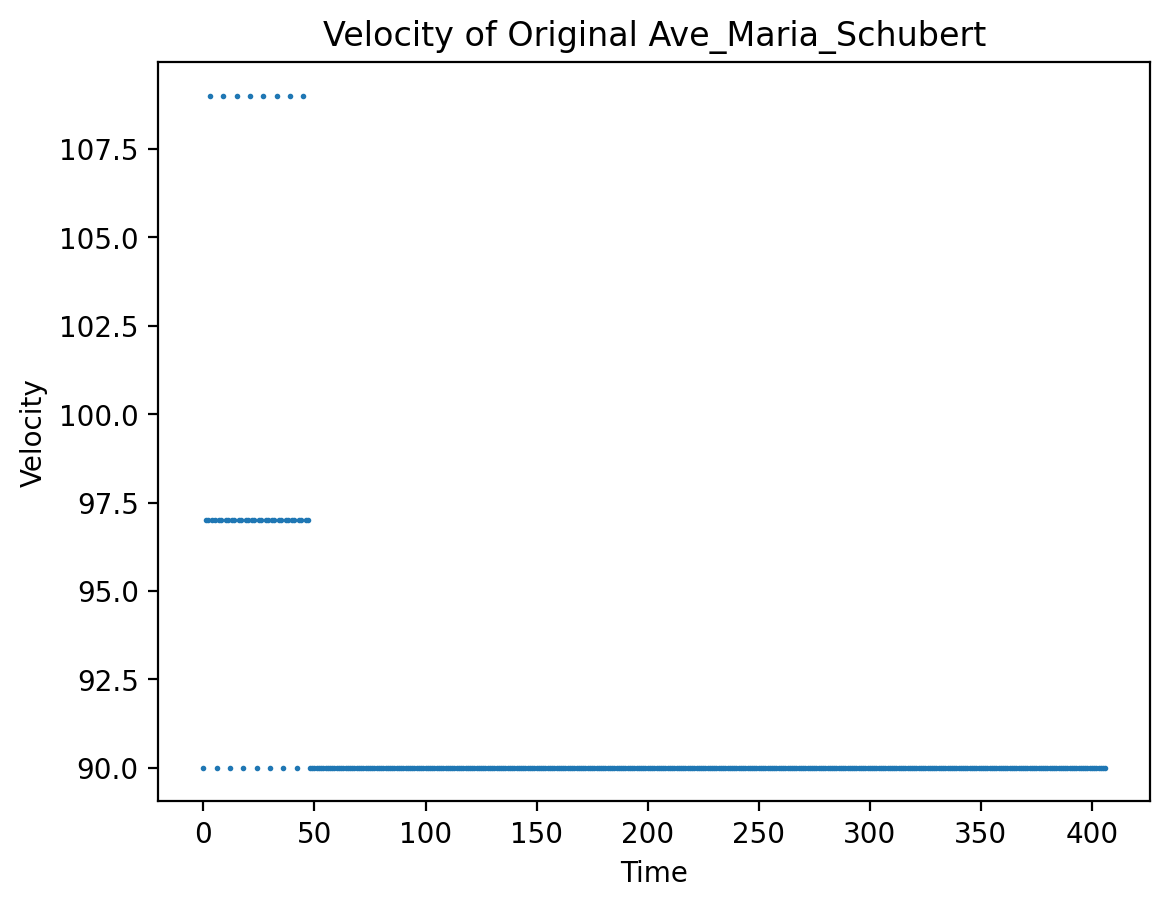

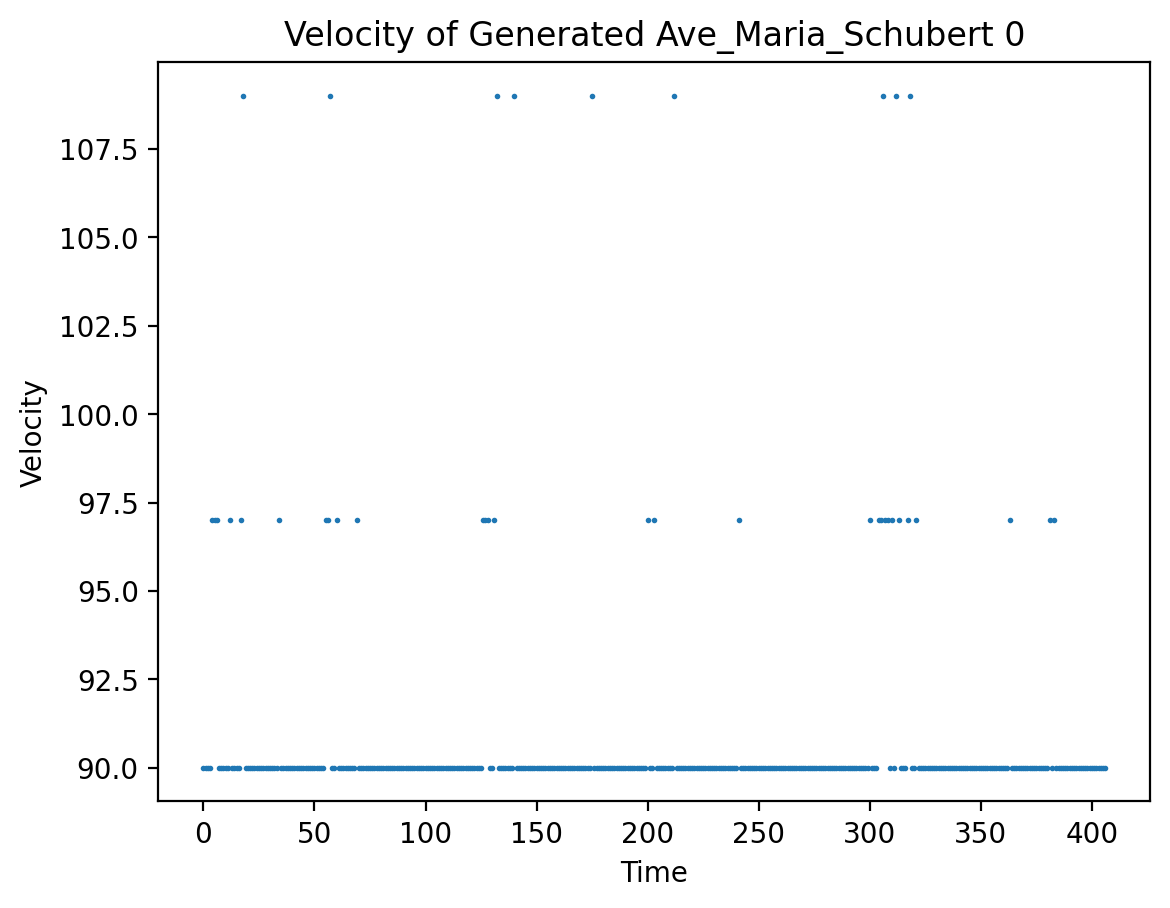

song_name: Ave_Maria_Schubert , number: 0


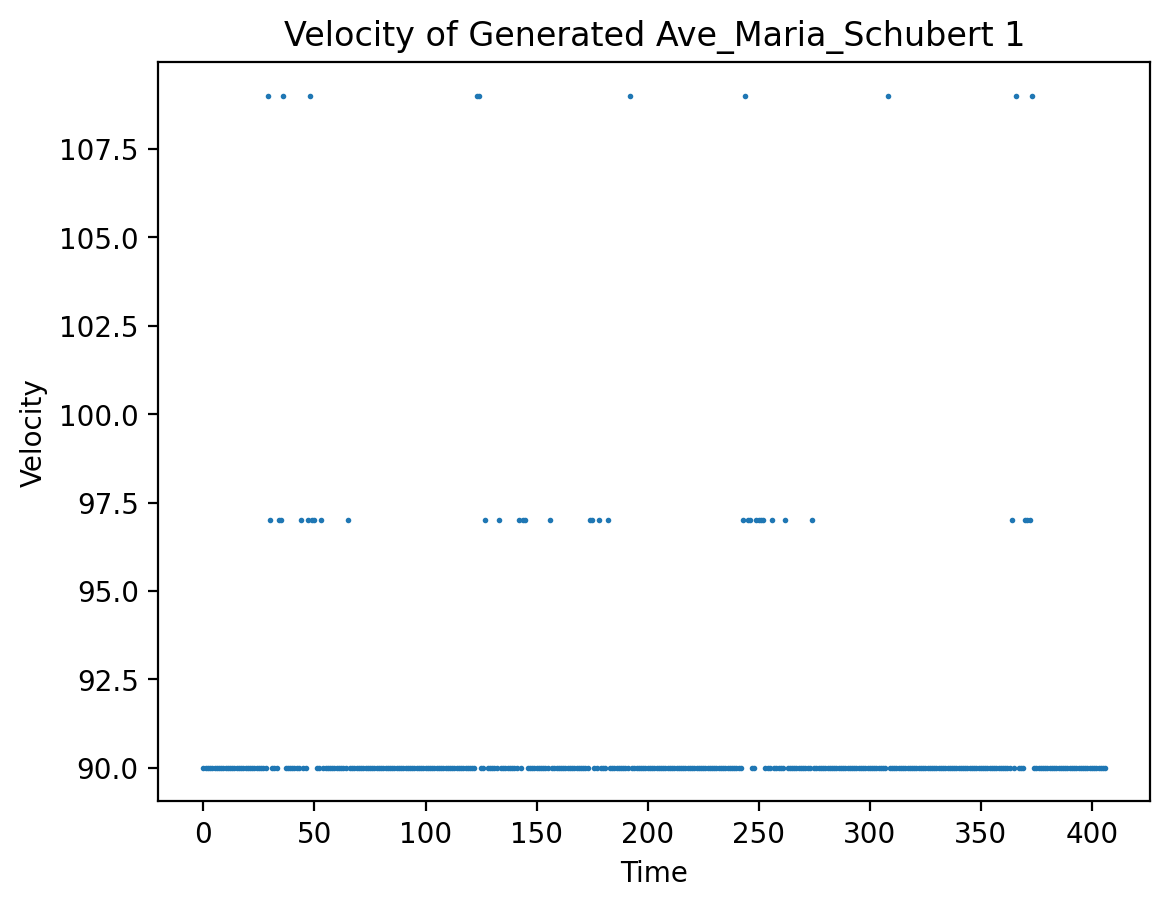

song_name: Ave_Maria_Schubert , number: 1


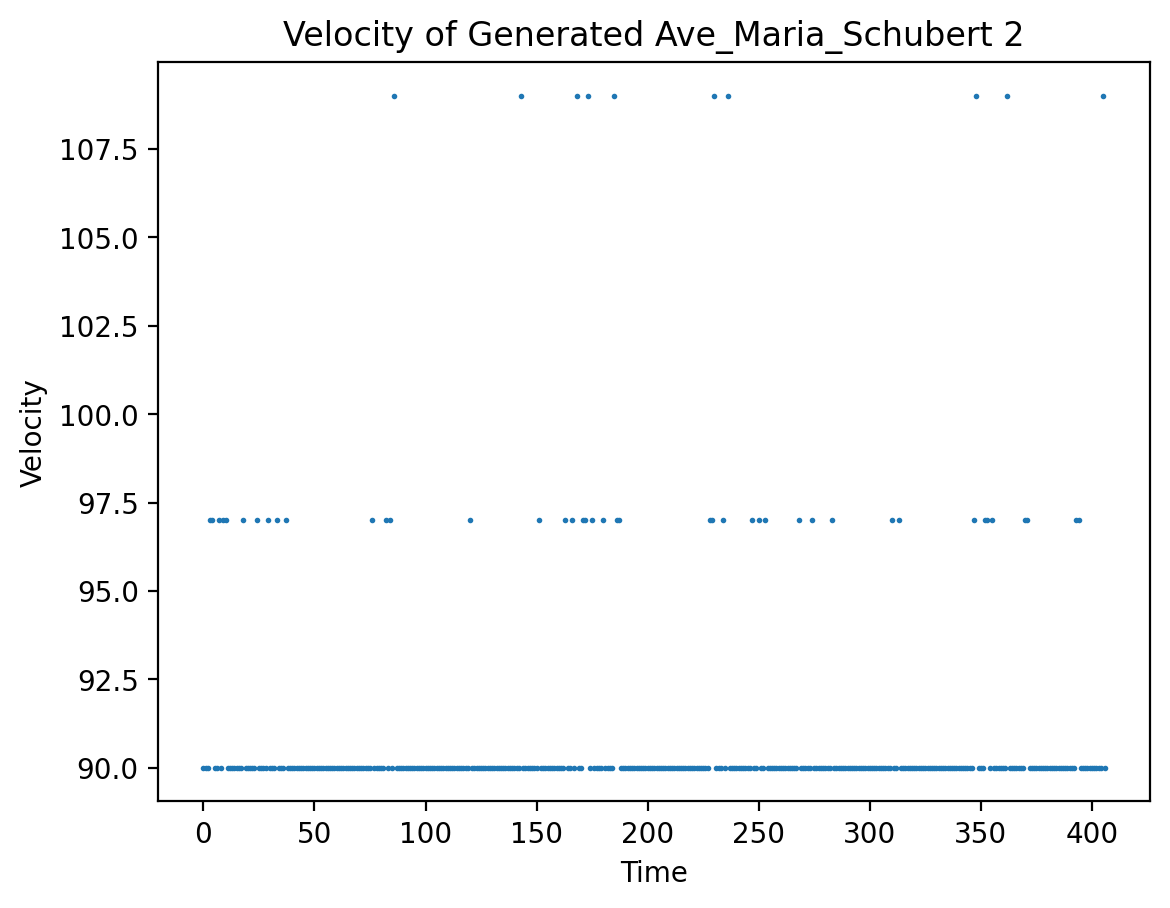

song_name: Ave_Maria_Schubert , number: 2


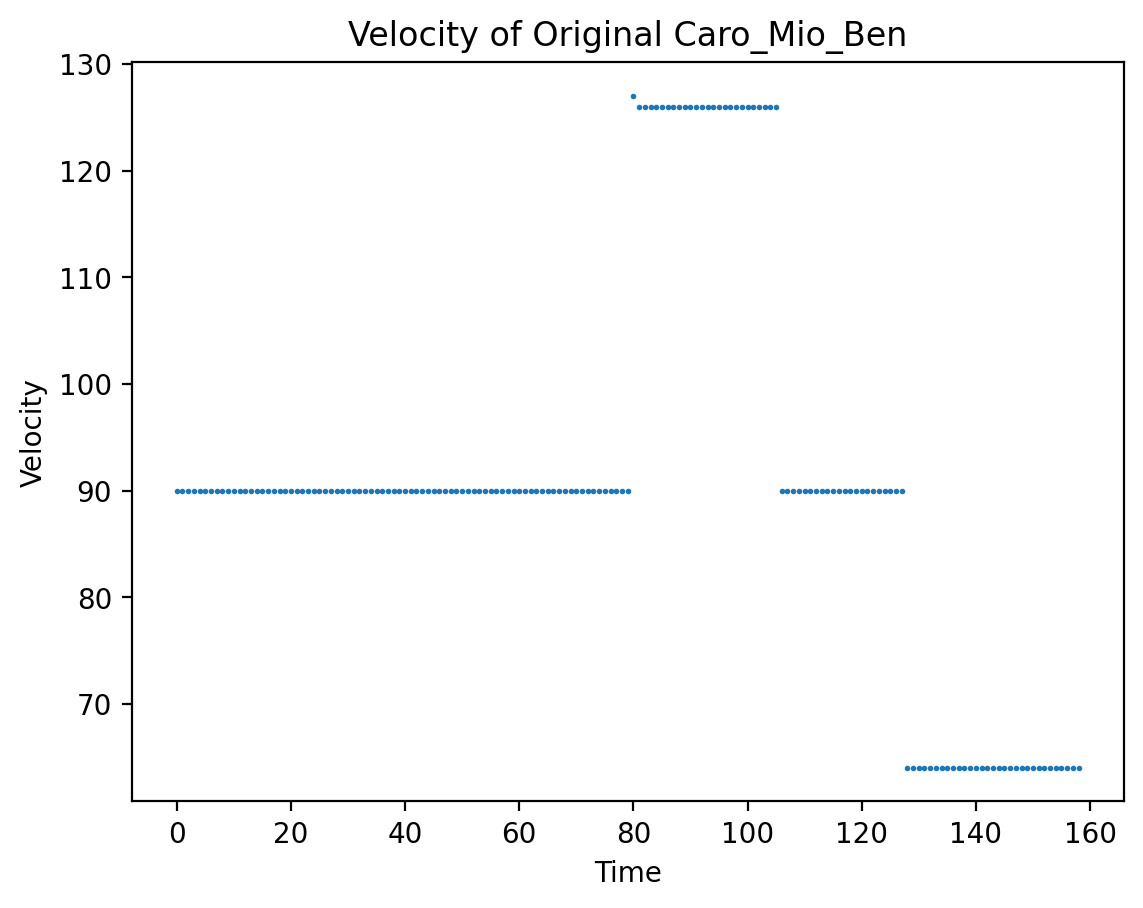

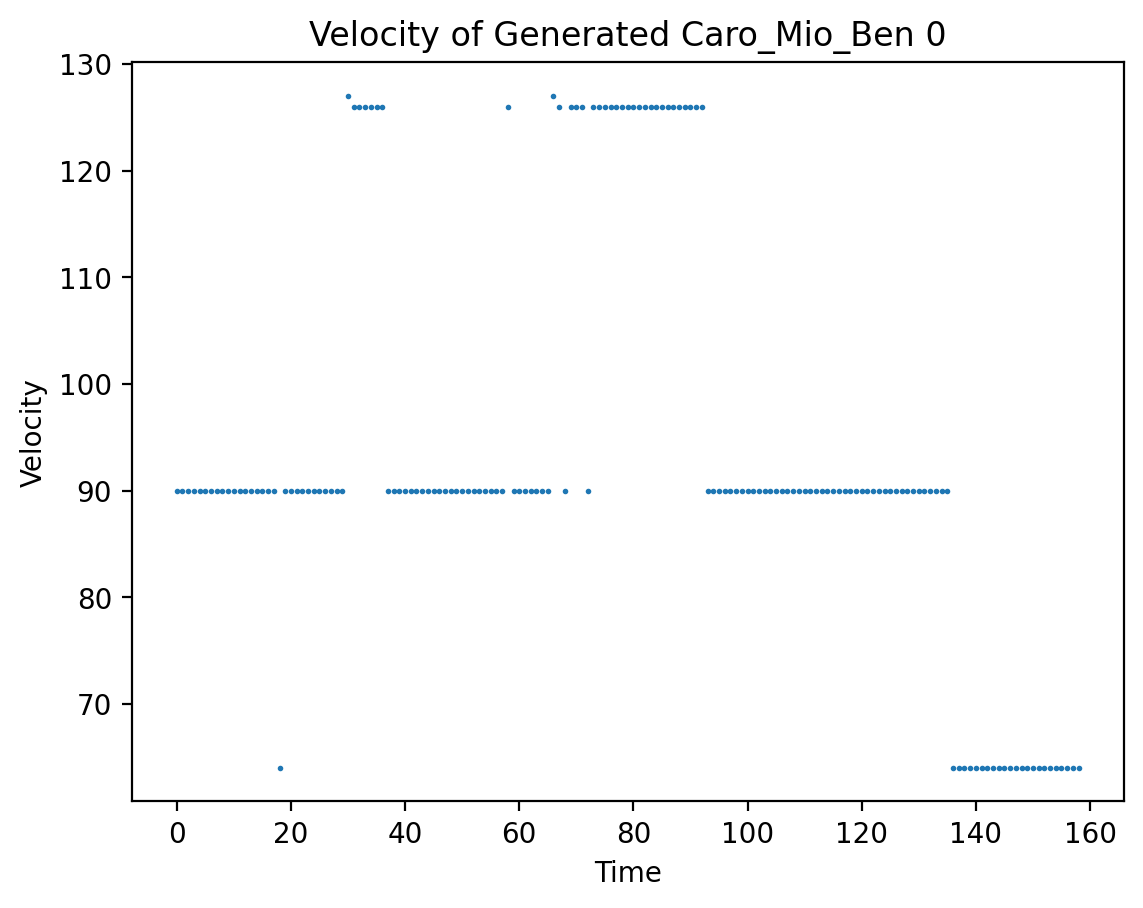

song_name: Caro_Mio_Ben , number: 0


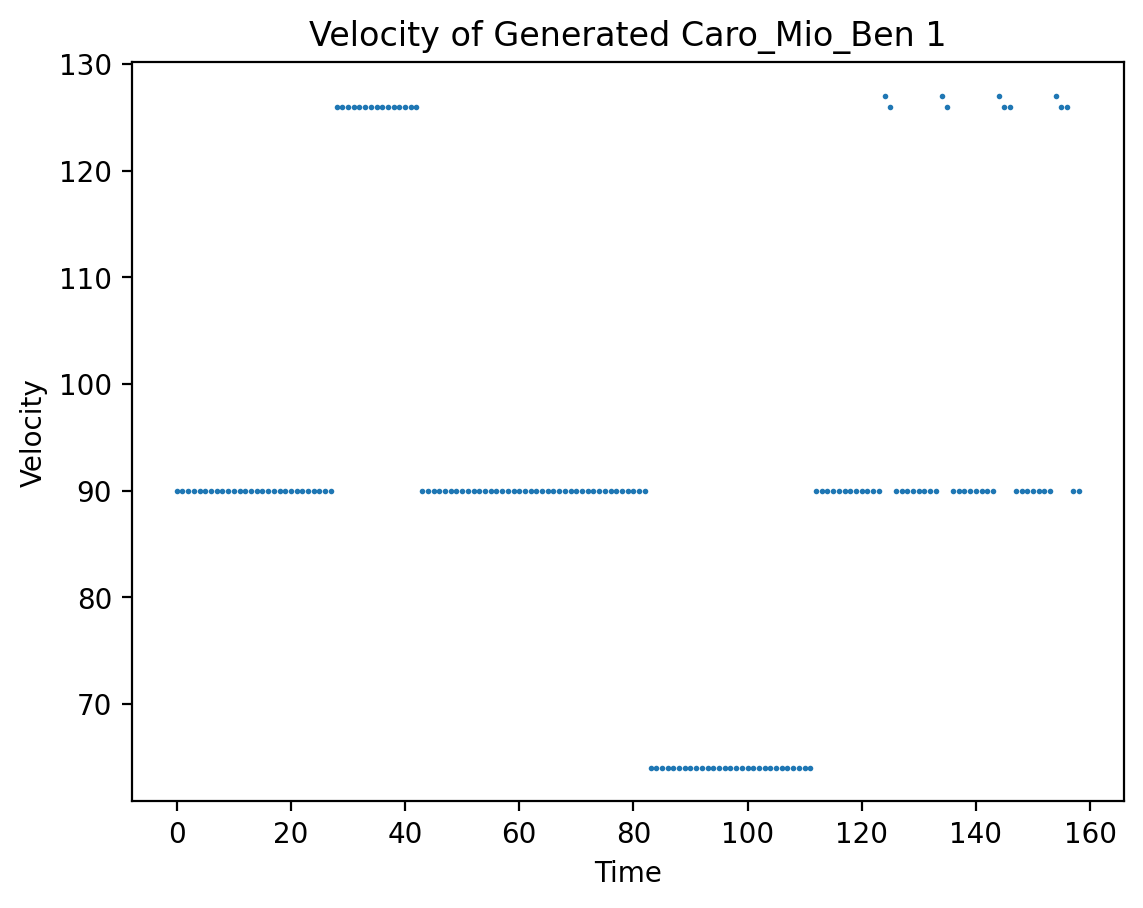

song_name: Caro_Mio_Ben , number: 1


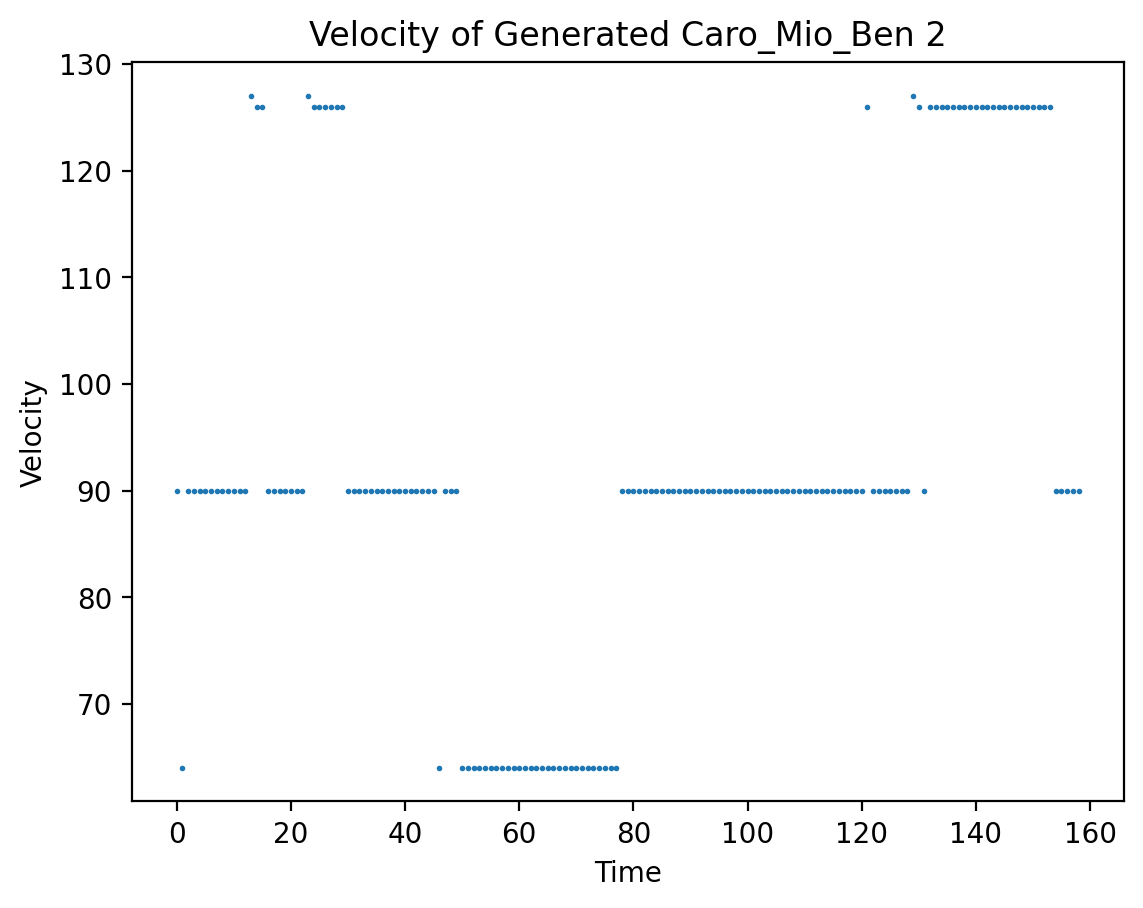

song_name: Caro_Mio_Ben , number: 2


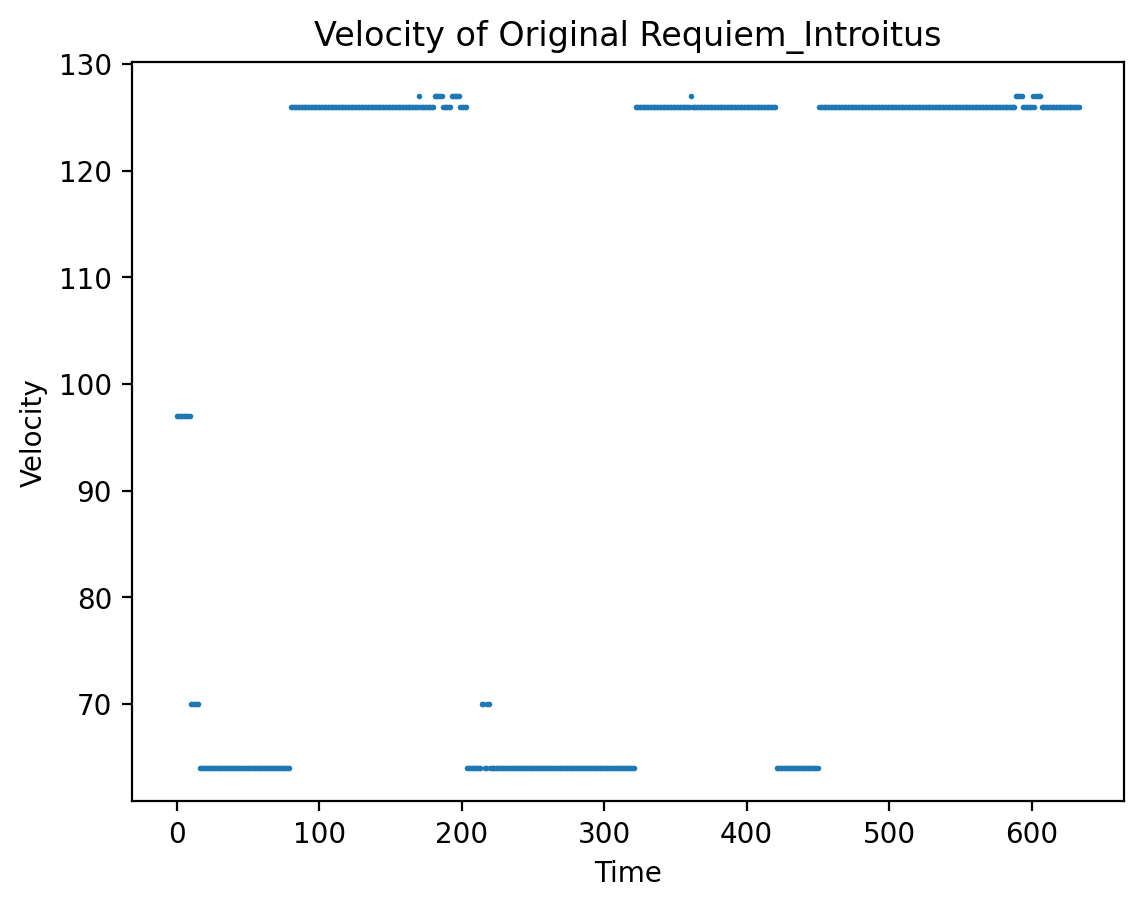

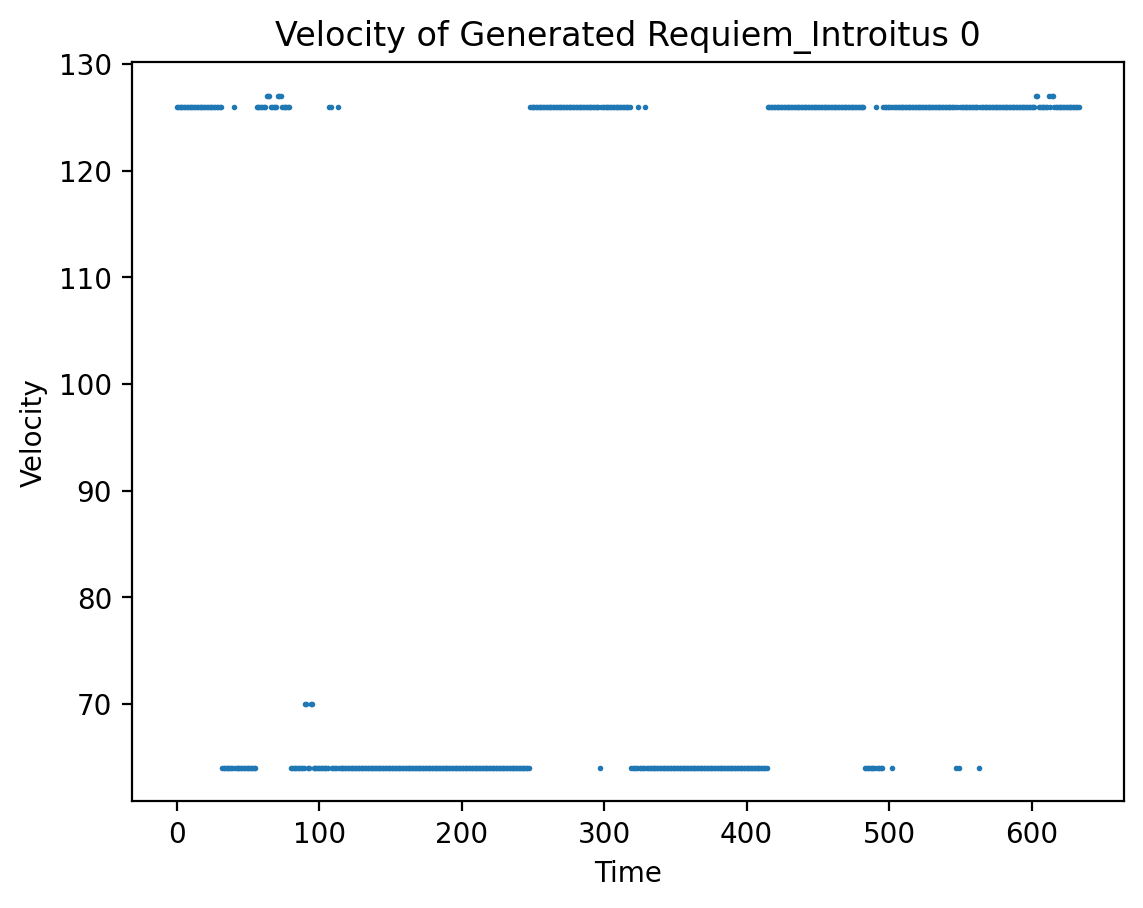

song_name: Requiem_Introitus , number: 0


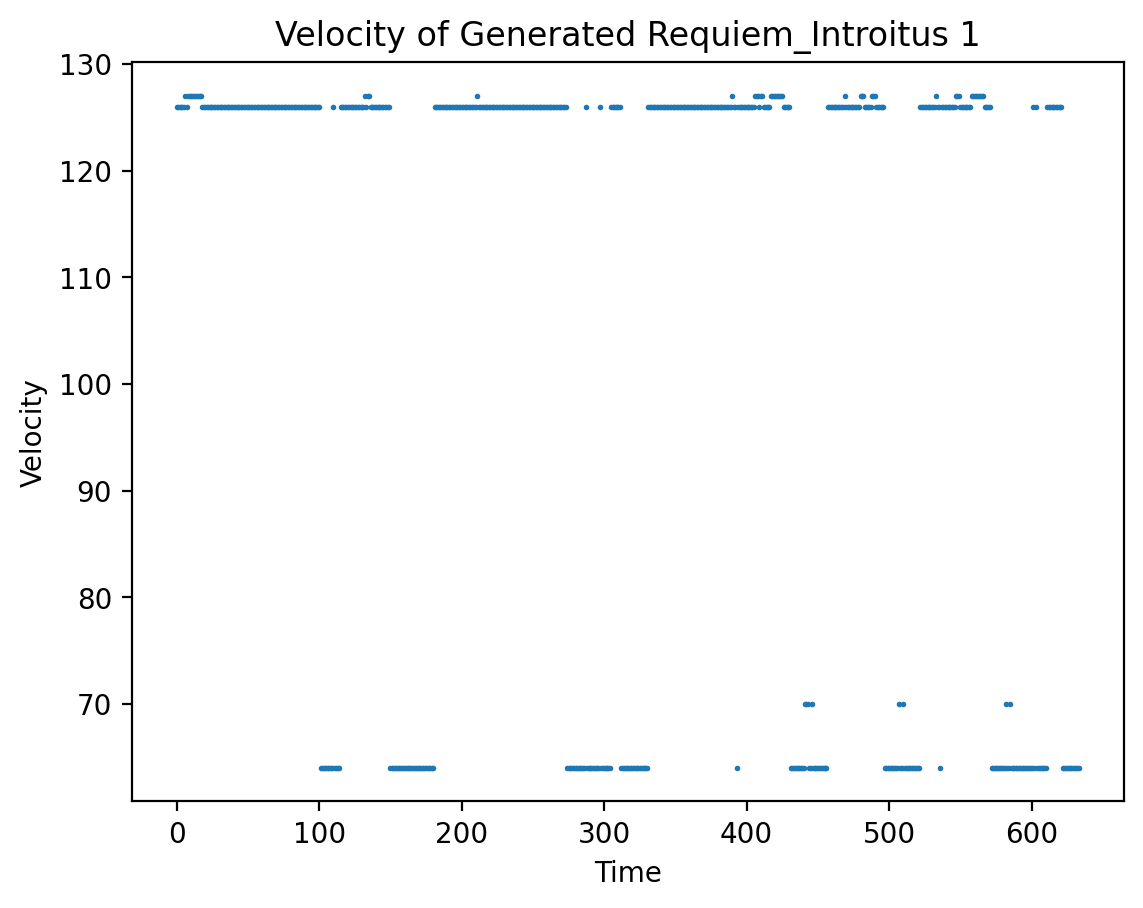

song_name: Requiem_Introitus , number: 1


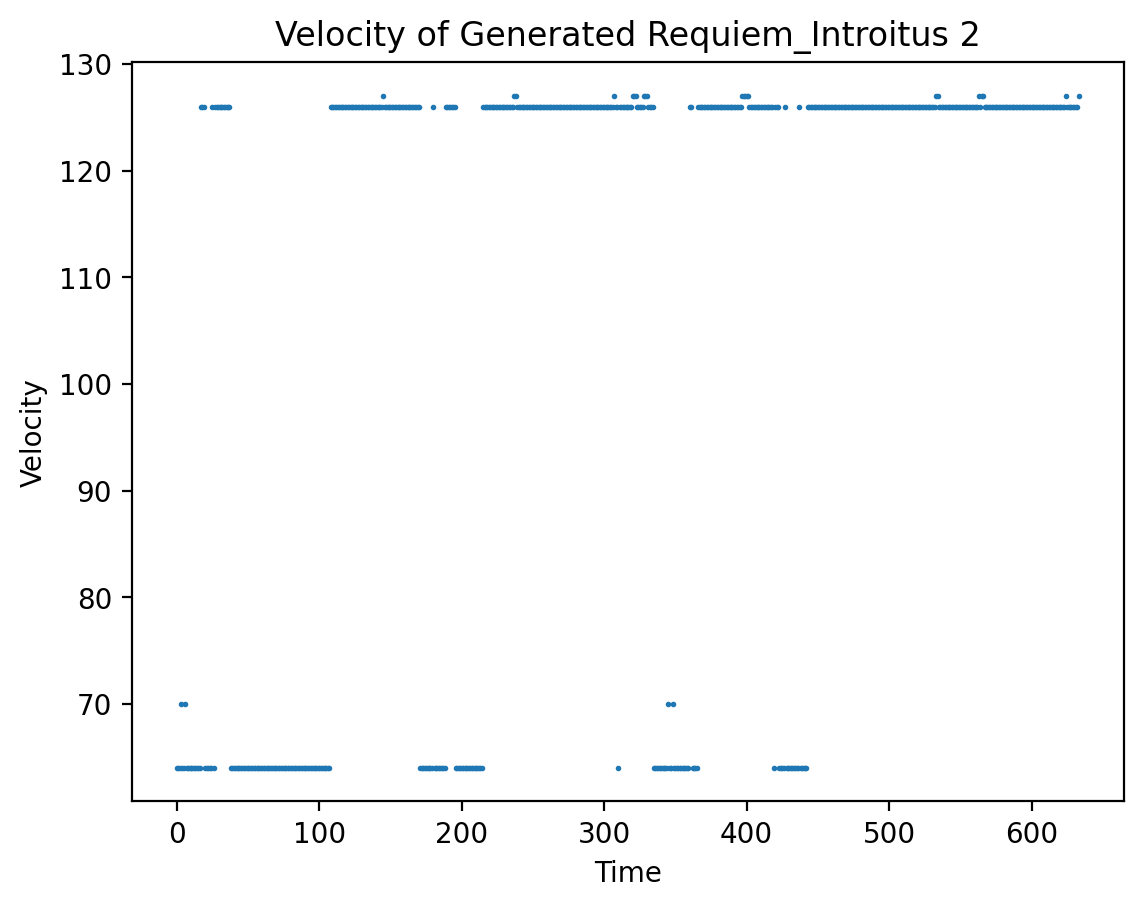

beam: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 11 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/stop>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/stop>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/partial/r

song_name: Requiem_Introitus , number: 2


In [13]:
filepath_list = ["Music Files\\09._Mary_had_a_little_lamb.mxl",
                 "Music Files\\Ave_Maria.mxl",
                 "Music Files\\Caro_Mio_Ben.mxl",
                 "Music Files\\Requiem_in_D_Minor_K._626_I._Introitus_Requiem_Aeternam_By_W._A._Mozart.mxl"]
names = ["Mary_had_a_little_lamb", 
         "Ave_Maria_Schubert",
         "Caro_Mio_Ben", 
         "Requiem_Introitus"]
run_multiple_songs(filepath_list, names, 3, True)